<a href="https://colab.research.google.com/github/benjaminnigjeh/keyProteoforms/blob/main/generalized_similarity_search_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import hashlib
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pickle

np.random.seed(42)
tf.random.set_seed(42)
random.seed(100)

In [2]:
class MinHash:
    def __init__(self, num_hashes=100):
        self.num_hashes = num_hashes
        self.seeds = [random.randint(0, 2**32 - 1) for _ in range(num_hashes)]

    def _hash(self, x, seed):
        return int(hashlib.md5((str(seed) + x).encode('utf8')).hexdigest(), 16)

    def compute(self, set_data):
        min_hashes = [min(self._hash(el, seed) for el in set_data) for seed in self.seeds]
        return min_hashes

    def jaccard_similarity(self, set1, set2):
        min_hash1 = self.compute(set1)
        min_hash2 = self.compute(set2)
        return sum(1 for a, b in zip(min_hash1, min_hash2) if a == b) / self.num_hashes


def hashing(str1, str2):

    n = 3
    set1 = {str1[i:i+n] for i in range(len(str1) - n + 1)}
    set2 = {str2[i:i+n] for i in range(len(str2) - n + 1)}
    minhash = MinHash(num_hashes=100)
    similarity = minhash.jaccard_similarity(set1, set2)
    return(1 - similarity)

def plot_distribution(data):
    if isinstance(data, list):
        data = np.array(data)

    plt.figure(figsize=(10, 6))

    sns.histplot(data, bins=30, kde=True, color='blue', alpha=0.6, stat='density')

    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Distribution of Numbers')

    plt.grid(True)
    plt.show()

def plot_confusion_matrix(model, X_test, y_test):
  y_true = [0 if x < 0.5 else 1 for x in y_test]
  y_pred = [0 if x < 0.5 else 1 for x in model.predict(X_test)]

  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
  disp.plot(cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.show()

In [16]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_hdf("/content/drive/MyDrive/databank_updated", key="databank")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
df.columns

Index(['sample_name', 'group_name', 'sample_prep', 'scan', 'scan_type',
       'retntion time', 'm/z', 'cast spectra', 'sequence', 'MASS',
       'Uniprot ID', 'Accession'],
      dtype='object')

In [18]:
a = df['Uniprot ID'].unique()
b = df['Uniprot ID'].value_counts().reindex(a, fill_value=0).tolist()

sorted_accessions = sorted(zip(a, b), key=lambda x: x[1], reverse=True)

sorted_accessions[1][0]

'MBP_HUMAN'

In [19]:
df = df.copy()

In [20]:
id = []
sequence = []
cast = []

for i in range(0, len(df['scan'])):
    if df['scan_type'][i] == 'MS2':
        if df['Uniprot ID'][i] != 'None':
            id.append(df['Uniprot ID'][i])
            sequence.append(df['sequence'][i])
            cast.append(df['cast spectra'][i])

ref_seq = 'MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKEGVVHGVATVAEKTKEQVTNVGGAVVTGVTAVAQKTVEGAGSIAAATGFVKKDQLGKNEEGAPQEGILEDMPVDPDNEAYEMPSEEGYQDYEPEA'

In [21]:
len(id)

4485

In [ ]:
cast_flat = []
hash = []

for i in range(0, len(sequence)):
    print(i)
    cast_flat.append(cast[i])
    hash.append(hashing(sequence[i], ref_seq))

X = np.array(cast_flat)
y = np.array(hash)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.1901 - mae: 0.4279 - val_loss: 0.0914 - val_mae: 0.2586
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0814 - mae: 0.2265 - val_loss: 0.0649 - val_mae: 0.1535
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0615 - mae: 0.1455 - val_loss: 0.0559 - val_mae: 0.1310
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0541 - mae: 0.1271 - val_loss: 0.0487 - val_mae: 0.1212
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0472 - mae: 0.1174 - val_loss: 0.0408 - val_mae: 0.1105
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0395 - mae: 0.1069 - val_loss: 0.0332 - val_mae: 0.1004
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0314 - mae: 0.0964 - val_loss: 0.0256 - val_mae: 0.0875
Epoch 8/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0227 - mae: 0.0821 - val_loss: 0.0203 - val_mae: 0.0748
Epoch 9/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0164 - mae: 0.0683 - 

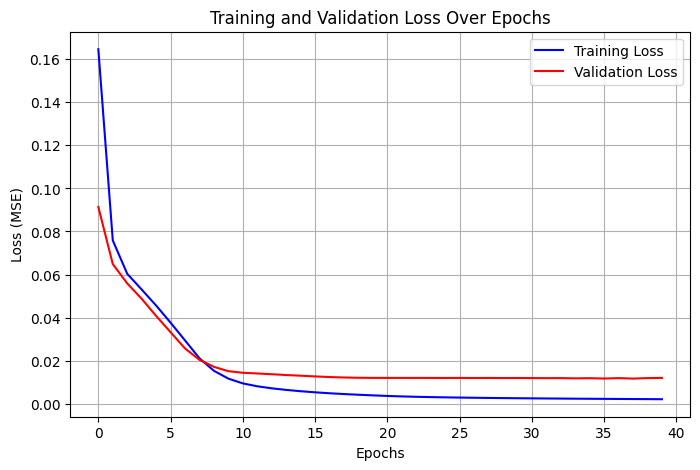

In [23]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(1600,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model and store training history
history = model.fit(X_train, y_train, epochs=40, batch_size=512, validation_split=0.2)

# Evaluate on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss:.4f}")

# 🎨 Plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


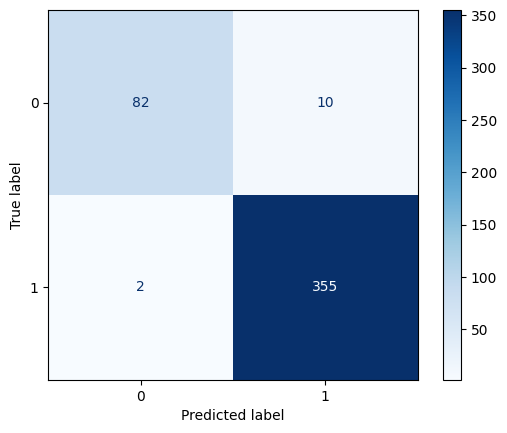

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, X_test, y_test):
    # Ensure y_test is binary (0 or 1)
    #y_test = np.array(y_test).astype(int)  # ✅ Convert to integer if needed
    y_test = np.where(np.array(y_test) > 0.5, 1, 0).astype(int)

    # Get model predictions
    y_scores = model.predict(X_test)

    # Convert predictions to binary labels
    y_pred = (y_scores >= 0.5).astype(int).flatten()  # ✅ Convert float → int

    # Ensure shapes match
    if y_test.shape != y_pred.shape:
        print(f"Shape mismatch: y_test {y_test.shape}, y_pred {y_pred.shape}")
        y_test = y_test.flatten()

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)

    # Show the plot
    plt.show()

# Call the function
plot_confusion_matrix(model, X_test, y_test)

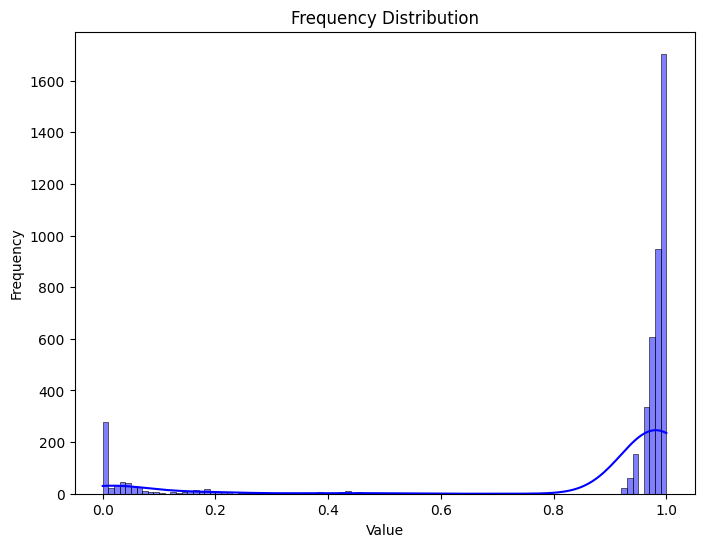

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate sample data
data = np.array(hash)  # Normally distributed data

# Plot the frequency distribution
plt.figure(figsize=(8, 6))
sns.histplot(data, bins=100, kde=True, color='blue', legend=False)

#plt.yscale('log', base=2)
# Labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency Distribution')

# Show the plot
plt.show()


In [26]:

cast = []

for i in range(0, len(df['scan'])):
    if df['scan_type'][i] == 'MS2':
          cast.append(df['cast spectra'][i])

hash = model.predict(np.array(cast))


602/602 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [27]:
X = np.array(cast)
y = np.array(hash)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)


In [28]:
for layer in model.layers:
        layer.trainable = False

    # Create a new Sequential model and add the old model as a base
new_model = tf.keras.Sequential([
        model,  # Include the original model
        tf.keras.layers.Dense(32, activation='relu', dtype='float16'),  # New layer
        tf.keras.layers.Dense(1, activation='sigmoid', dtype='float16')  # Output layer
    ])


new_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = new_model.fit(X_train, y_train, epochs=5, batch_size=512, validation_split=0.2)

for layer in model.layers[-2:]:
        layer.trainable = True

# Recompile after unfreezing layers
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='mean_squared_error', metrics=['mae'])

# Continue fine-tuning
history_finetune = new_model.fit(X_train, y_train, epochs=10, batch_size=512, validation_split=0.2)



Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1706 - mae: 0.3611 - val_loss: 0.0491 - val_mae: 0.1140
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0330 - mae: 0.1015 - val_loss: 0.0219 - val_mae: 0.1018
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0187 - mae: 0.0887 - val_loss: 0.0196 - val_mae: 0.0893
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0170 - mae: 0.0831 - val_loss: 0.0187 - val_mae: 0.0837
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0161 - mae: 0.0779 - val_loss: 0.0179 - val_mae: 0.0806
Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0155 - mae: 0.0756 - val_loss: 0.0178 - val_mae: 0.0800
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0154 - mae: 0.0751 - val_loss: 0.0177 - val_mae: 0.0793
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0153 - mae: 0.0745 - val_loss: 0.0176 - val_mae: 0.0788
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0152 - m

In [ ]:
cast = []

for i in range(0, len(df['scan'])):
    if df['scan_type'][i] == 'MS2':
      if df['Uniprot ID'][i] == 'None':
          cast.append(df['cast spectra'][i])

hash = model.predict(np.array(cast))

a = 0
b = 0

for i in range(0, len(hash)):
  if hash[i] > 0.5:
    a += 1
  else:
    b += 1

print(a)
print(b)